# Titanic: Machine Learning from Disaster

**Kaggle competition**

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

**Expected Process**
* Exploratory data analysis and feature engineering
* Comparing the model's precision
* Submission

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape, test.shape)
display(train.head(2), test.head(2))
print(train.info(), test.info())

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

Missing Information: **Train** Age, Cabin and **Test** Age, Fare, Cabin

## 1. Exploratory data analysis and feature engineering

### 1.1. Sex

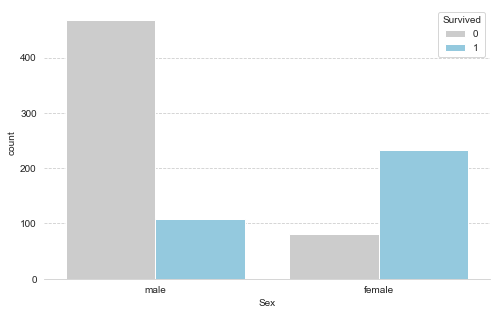

In [3]:
def chart(by):
    plt.figure(figsize = (8,5))
    colors = ['.8','skyblue']
    sns.set_style("whitegrid", {'axes.grid': True, 'grid.linestyle': '--'})
    sns.countplot(data = train, x = by, hue = 'Survived', palette = colors)
    sns.despine(left = True, right = True, top = True)

chart('Sex')


**Female passengers are survived more** than Male passengers

In [4]:
# Sex encoding

train.loc[train.Sex == 'male', 'sex_e'] = 0
train.loc[train.Sex == 'female', 'sex_e'] = 1
test.loc[test.Sex == 'male', 'sex_e'] = 0
test.loc[test.Sex == 'female', 'sex_e'] = 1

print(train.Sex.value_counts(), '\n'*2 ,test.Sex.value_counts())


male      577
female    314
Name: Sex, dtype: int64 

 male      266
female    152
Name: Sex, dtype: int64


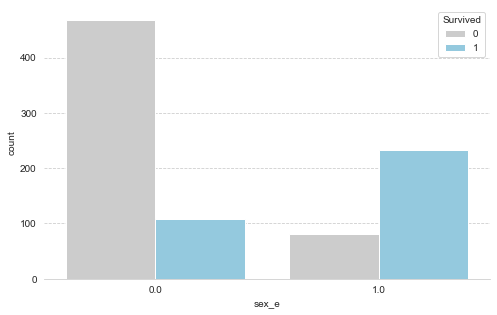

In [5]:
chart('sex_e')

### 1.2. Name - Title

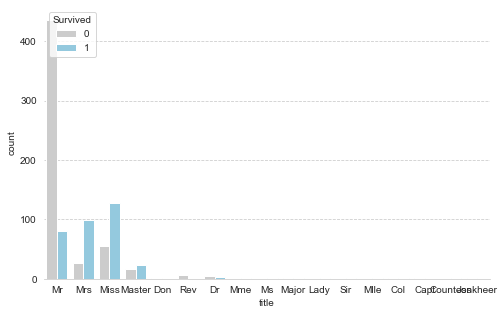

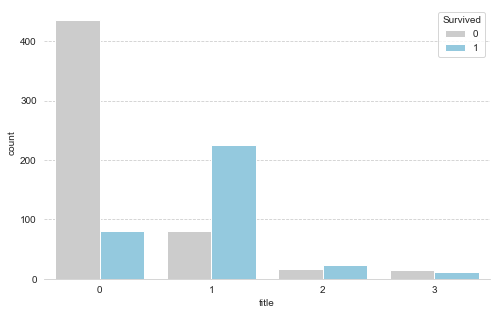

In [6]:
# Extracting titles from the name
# train['title'] = train.Name.str.split(', ').str[1].str.split('.').str[0]
train['title'] = train.Name.str.extract('([A-Za-z]+)\.', expand = False)
test['title'] = test.Name.str.extract('([A-Za-z]+)\.', expand = False)

chart('title')

# Simplifying the minor title to Master
def name_e(row):    
    if row == 'Mr' : return 0
    elif row == 'Miss' or row == 'Mrs': return 1
    elif row == 'Master': return 2
    else: return 3
    
train.title = train['title'].apply(name_e)
test.title = test['title'].apply(name_e)


chart('title')

**Mrs, Miss, Master title survived more** than other titles

### 1.3. Pclass

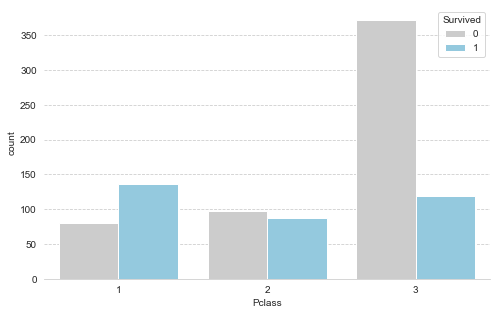

In [7]:
chart('Pclass')

**1st class passenger are survived** more than other classes passengers

### 1.4. Age

/Users/jongwoop/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/jongwoop/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


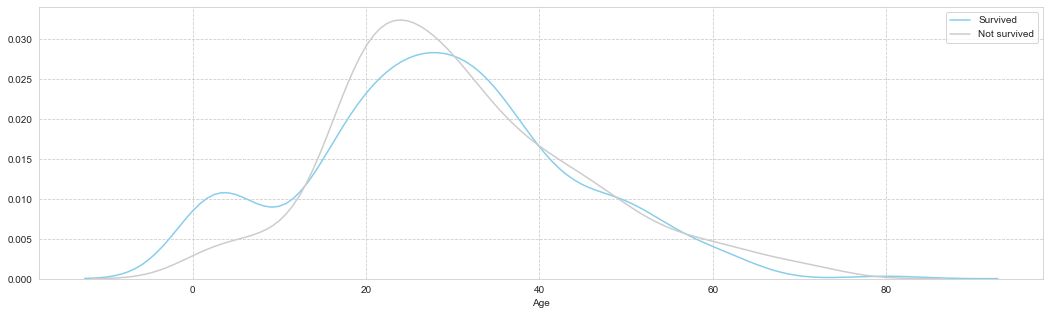

In [8]:
# g = sns.FacetGrid(train, row = 'Age', hue =  'Survived')
# g = g.map(s, 'Survived')
plt.figure(figsize = [18,5])
sns.distplot(train[train.Survived == 1].Age, hist = False, label = 'Survived', color = 'skyblue')
sns.distplot(train[train.Survived == 0].Age, hist = False, label = 'Not survived', color = '.8')


Can confirm **the age under 15 survived more**, so grouping the age based on age 15

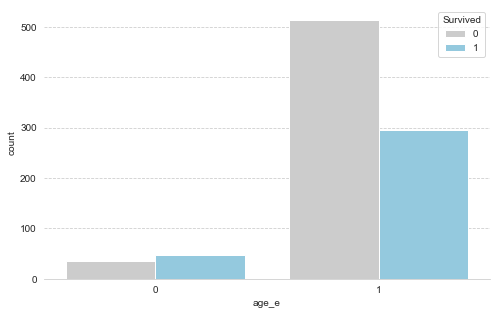

In [9]:
# Filling the missing data

train['Age'].fillna(train.groupby('title')['Age'].transform('median'), inplace = True)
test['Age'].fillna(test.groupby('title')['Age'].transform('median'), inplace = True)

# ## Age Encoding

def age_e(row):    
    if row < 15 : return 0
    else: return 1

train['age_e'] = train.Age.apply(age_e)
test['age_e'] = test.Age.apply(age_e)

chart('age_e')

### 1.5. Fare

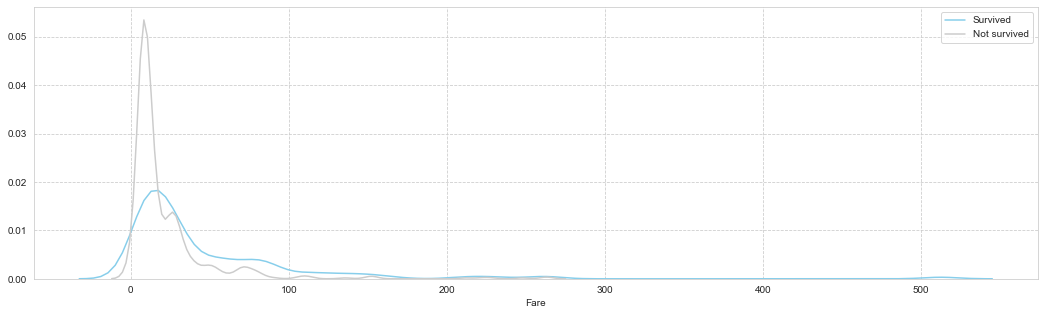

In [10]:
plt.figure(figsize = [18,5])
sns.distplot(train[train.Survived == 1].Fare, hist = False, label = 'Survived', color = 'skyblue')
sns.distplot(train[train.Survived == 0].Fare, hist = False, label = 'Not survived', color = '.8')



Can confirm the **fare over 30 dollar survived more** therevore grouped based on that criteria

In [11]:
test.Fare.fillna(test[test.Pclass == 3].groupby('Pclass')['Fare'].transform('median'), inplace = True)
test.Fare.isnull().value_counts()

False    418
Name: Fare, dtype: int64

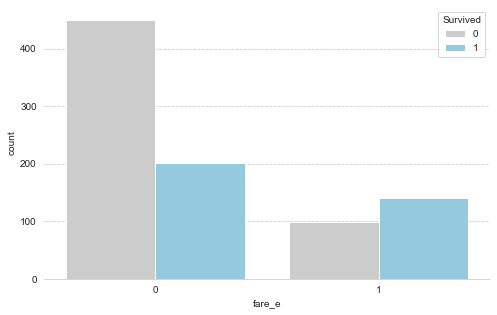

In [12]:
## Fare Encoding

def fare_e(row):    
    if row < 30 : return 0
    else: return 1

train['fare_e'] = train.Fare.apply(fare_e)
test['fare_e'] = test.Fare.apply(fare_e)

chart('fare_e')

### 1.6. Embarked

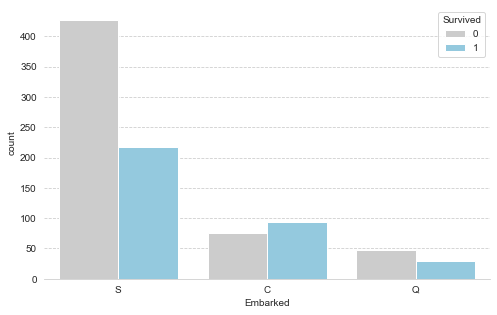

In [13]:
chart('Embarked')

In [14]:
# Mising Values - adding most highest Embarked count S
train.Embarked.fillna('S', inplace = True)

# Encoding

train.loc[train.Embarked.str.contains('C'), 'embarked_e'] = 0
train.loc[train.Embarked.str.contains('S'), 'embarked_e'] = 1
train.loc[train.Embarked.str.contains('Q'), 'embarked_e'] = 2

test.loc[test.Embarked.str.contains('C'), 'embarked_e'] = 0
test.loc[test.Embarked.str.contains('S'), 'embarked_e'] = 1
test.loc[test.Embarked.str.contains('Q'), 'embarked_e'] = 2

test.embarked_e.value_counts()

1.0    270
0.0    102
2.0     46
Name: embarked_e, dtype: int64

**Passenger embarked in C survived slightly more** than passengers who are embarked from other places.

### 1.6. Family

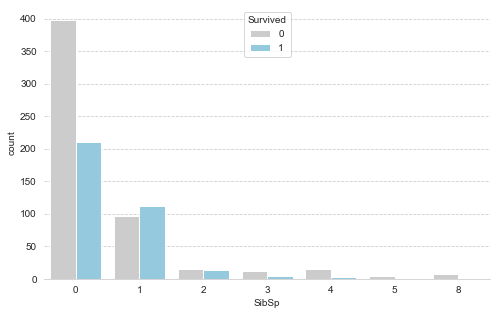

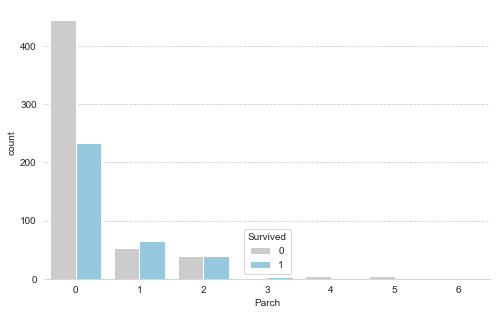

In [15]:
chart('SibSp')
chart('Parch')

* SibSp chart confirms people who has only **one sibling or spouse are survived** more than else.
* Parch chart confirms people who has at least **1-2 parent or children are survived** more than else.

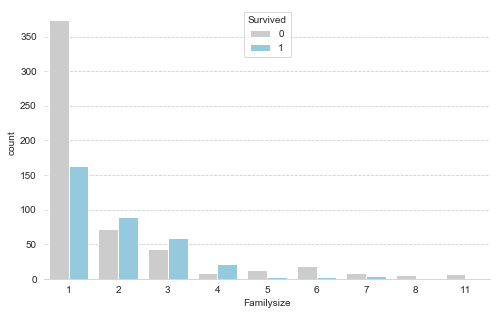

In [16]:
# Family = SibSp + Parch + 1(Me)
train['Familysize'] = train.SibSp + train.Parch + 1
test['Familysize'] = test.SibSp + test.Parch + 1

chart('Familysize')

We can figure out that **paseenger whose family size >=2 and <5 are survived more**, 
so we will grouping based on family size as **single**(1), **nuclear**(2-4), **big**(5-)

In [17]:
def familytype(row):
    if row == 1: return 0
    elif row > 1 and row < 5: return 1
    else: return 2

train['familytype'] = train['Familysize'].apply(familytype)
test['familytype'] = test['Familysize'].apply(familytype)


In [18]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_e,title,age_e,fare_e,embarked_e,Familysize,familytype
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0,1,0,1.0,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1,1,1,0.0,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,1,1,0,1.0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,1,1,1,1.0,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,0,1,0,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0,3,1,0,1.0,1,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0,1,1,1,1.0,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,27.0,1,2,W./C. 6607,23.4500,NaN,S,1.0,1,1,0,1.0,4,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.0,0,1,1,0.0,1,0


### 1.7. Cabin

True     687
False    204
Name: cabin_e, dtype: int64 

 True     327
False     91
Name: Cabin, dtype: int64


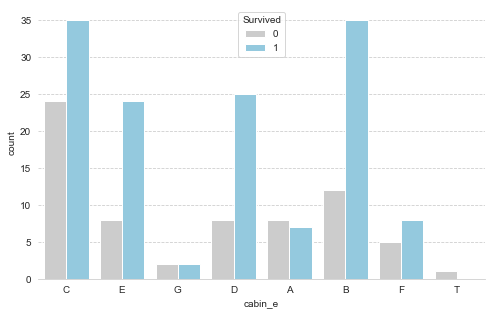

In [19]:
train['cabin_e'] = train.Cabin.str[:1]
print(train.cabin_e.isnull().value_counts(), '\n'*2, test.Cabin.isnull().value_counts())
chart('cabin_e')

In [20]:
train.groupby('cabin_e').Fare.mean()

cabin_e
A     39.623887
B    113.505764
C    100.151341
D     57.244576
E     46.026694
F     18.696792
G     13.581250
T     35.500000
Name: Fare, dtype: float64

In [21]:
train.groupby('cabin_e').Familysize.mean()

cabin_e
A    1.266667
B    1.936170
C    2.118644
D    1.727273
E    1.625000
F    2.076923
G    2.750000
T    1.000000
Name: Familysize, dtype: float64

Exisitng data for Cabin(**train(687/891)**, **test(327/418)**) are low, therefore concluded to skip from the feature

## 2. Modeling

### 2.1. Selecting Features

In [22]:
display(train.head(2), test.head(2))
print(train.columns, test.columns)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_e,title,age_e,fare_e,embarked_e,Familysize,familytype,cabin_e
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0,1,0,1.0,2,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1,1,1,0.0,2,1,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_e,title,age_e,fare_e,embarked_e,Familysize,familytype
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0,0,1,0,2.0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1.0,1,1,0,1.0,2,1


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'sex_e', 'title',
       'age_e', 'fare_e', 'embarked_e', 'Familysize', 'familytype', 'cabin_e'],
      dtype='object') Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'sex_e', 'title', 'age_e',
       'fare_e', 'embarked_e', 'Familysize', 'familytype'],
      dtype='object')


In [23]:
feature = ['title','Pclass', 'sex_e', 'age_e', 
        'Fare', 'familytype', 'embarked_e']
label = ['Survived']

train_x = train[feature]
train_y = train[label]
test_x = test[feature]

print(train_x.shape, train_y.shape, test_x.shape)

(891, 7) (891, 1) (418, 7)


In [24]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
title         891 non-null int64
Pclass        891 non-null int64
sex_e         891 non-null float64
age_e         891 non-null int64
Fare          891 non-null float64
familytype    891 non-null int64
embarked_e    891 non-null float64
dtypes: float64(3), int64(4)
memory usage: 48.9 KB


### 2.2. Importing classifier modules and comparing the scores

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

### 2.2.1. KNN

In [26]:
model = KNeighborsClassifier()
scoring = 'accuracy'
score = cross_val_score(model, train_x, train_y, cv = k_fold, n_jobs = -1, scoring = scoring)
print(score)

[0.73333333 0.82022472 0.83146067 0.73033708 0.84269663 0.85393258
 0.75280899 0.75280899 0.74157303 0.78651685]


In [27]:
# KNN Score
round(np.mean(score) * 100, 2)

78.46

### 2.2.2. Decision Tree

In [28]:
# DecisionTree, score: 0.78947, w/o Encoding Fare, Kaggle Public Score: 0.79904

model = DecisionTreeClassifier(max_depth = 8, random_state = 0)
scoring = 'accuracy'
score = cross_val_score(model, train_x, train_y, cv = k_fold, n_jobs = -1, scoring = scoring)
print(score)

[0.77777778 0.88764045 0.84269663 0.83146067 0.85393258 0.83146067
 0.85393258 0.80898876 0.74157303 0.85393258]


In [29]:
# DecisionTree Score 
round(np.mean(score) * 100, 2)

82.83

### 2.2.3. RandomForest

In [30]:
model = RandomForestClassifier()
scoring = 'accuracy'
score = cross_val_score(model, train_x, train_y, cv = k_fold, n_jobs = -1, scoring = scoring)
print(score)

[0.81111111 0.87640449 0.82022472 0.78651685 0.80898876 0.80898876
 0.84269663 0.82022472 0.80898876 0.83146067]


In [31]:
# RandomForest Score
round(np.mean(score) * 100, 2)

82.16

### 2.2.4. Naive Bayes

In [32]:
model = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(model, train_x, train_y, cv = k_fold, n_jobs = -1, scoring = scoring)
print(score)

[0.75555556 0.75280899 0.80898876 0.76404494 0.74157303 0.78651685
 0.7752809  0.78651685 0.78651685 0.82022472]


In [33]:
# Naive Bayes Score
round(np.mean(score) * 100, 2)

77.78

### 2.2.5. SVM

In [34]:
## Encoding, Kaggle Public Score: 0.78947, w/o Encoding Fare, Kaggle Public Score: 0.74641

model = SVC()
scoring = 'accuracy'
score = cross_val_score(model, train_x, train_y, cv = k_fold, n_jobs = -1, scoring = scoring)
print(score)

[0.78888889 0.80898876 0.80898876 0.74157303 0.78651685 0.7752809
 0.82022472 0.83146067 0.78651685 0.84269663]


In [35]:
# SVM Score
round(np.mean(score) * 100, 2)

79.91

### 2.3. Testing - DecisionTree

In [36]:
model = DecisionTreeClassifier(max_depth = 8, random_state = 0)
model.fit(train_x, train_y)
prediction = model.predict(test_x)

In [37]:
submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': prediction})
submission.to_csv('submission_2.csv', index = False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
